In [1]:
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2

## Install package within conda using tensorflow
## /opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/bin/pip install tensorflow

In [2]:
fc = Fishnet.load("../Gis/Fishnet/fishnet_quarter_mile_completed.pkl")

In [3]:
# Compute Urbanization Rate
for year in [2017, 2018, 2019, 2020, 2021, 2022]:
    fc.compute_difference(f'MeanPixel_{year}', f'MeanPixel_{year-1}', filtered=True, normalize = True)

vars = ["id", "batch_id", "MeanPixel_2016", "MeanPixel_2017", "MeanPixel_2018", "MeanPixel_2019", "MeanPixel_2020", "MeanPixel_2021", "MeanPixel_2022"]
data = fc.filtered_fishnet[vars]
data.rename(columns={"id": "tile_id"}, inplace=True)
data["tile_id"] = data["tile_id"].astype(int)
data["batch_id"] = data["batch_id"].astype(int)

# Pivot wide to long
data = data.melt(id_vars=["tile_id", "batch_id"], var_name="year", value_name="urbanization")
data["urbanization"] = data["urbanization"] / 255 #normalization
data["year"] = data["year"].str[-4:]
data.head()

,tile_id,batch_id,year,urbanization
0,6060154,23743,2016,0.710556
1,6060155,23743,2016,0.802841
2,6060156,23743,2016,0.550000
3,6060157,23743,2016,0.447222
4,6060158,23743,2016,0.773333


In [4]:
#compute rows and cols in Fishnet
dc = fc.filtered_fishnet.copy()
L = dc["geometry"].bounds["maxx"].max() - dc["geometry"].bounds["minx"].min()
H = dc["geometry"].bounds["maxy"].max() - dc["geometry"].bounds["miny"].min()

rows = int(H / fc.tile_height_degrees)
cols = int(L / fc.tile_width_degrees)
print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 117, Number of columns: 193


In [5]:
# Generate tensor
years = ["2016", "2017", "2018", "2019", "2020", "2021", "2022"]
tensor = np.zeros((rows, cols, len(years)))

for yr in tqdm(years):
    tensor[:, :, years.index(yr)] = data[data["year"]== yr]["urbanization"].to_numpy().reshape(rows, cols)
tensor = tensor.reshape(len(years), rows, cols, 1)

100%|██████████| 7/7 [00:00<00:00, 156.22it/s]


In [6]:
tensor.shape

(7, 117, 193, 1)

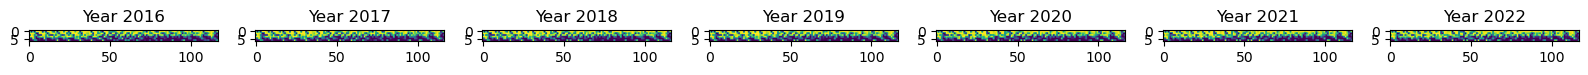

In [7]:
# plot consecutively to see the change
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(tensor[:, :, i])
    ax[i].set_title(f"Year {years[i]}")

# Now, we need to generate the dataset.

We need a data loader. We need to generate a dataset of that dimension:
(NBR_SAMPLE, TIME_SEQ, IMG_WIDTH, IMG_HEIGHT, CHANNELS)

@TODO:

1. Define proper loss function for the neural network
2. Check which frames are used for training
3. Add TensorBoard
4. Brainstorm the architecture
5. ✅ Start training from a pre-trained network


In [8]:
def extract_submatrix(matrix, length, step_size):
    submatrices = []
    rows, cols = matrix.shape
    for i in range(0, rows - (length - 1), step_size):
        for j in range(0, cols - (length - 1), 2):
            submatrix = matrix[i:i+length, j:j+length]
            submatrices.append(submatrix)
    return np.array(submatrices)

def generate_submatrices(tensor, years, length, step_size):
    submatrices = []
    for i, yr in enumerate(years):
        mat = tensor[i, :, :, 0]
        submatrices.append(extract_submatrix(mat, length, step_size))
    return np.array(submatrices).reshape(-1, len(years), length, length, 1)

In [9]:
TIME_SEQ = 7  # frames
IMG_SIZE = 5  # tiles
SLIDE_WDW = 2 # tiles

sub_matrices = generate_submatrices(tensor, years, IMG_SIZE, 2)
sub_matrices.shape

(5415, 7, 5, 5, 1)

In [10]:
sub_matrices.shape

(5415, 7, 5, 5, 1)

# Applying Keras' Tutorial Function to finish dataset generation

In [13]:
dataset = sub_matrices

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (4873, 6, 5, 5, 1), (4873, 6, 5, 5, 1)
Validation Dataset Shapes: (542, 6, 5, 5, 1), (542, 6, 5, 5, 1)


Displaying frames for example 2301.


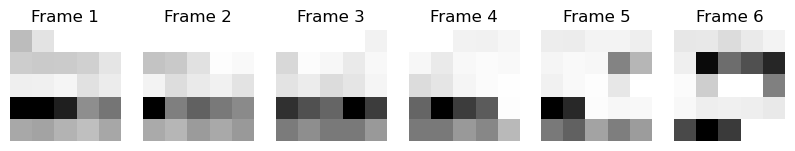

In [14]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 6, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import datetime

In [42]:
def create_model():

    # Construct the input layer with no definite frame size.
    inp = layers.Input(shape=(None, *x_train.shape[2:]))

    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    # followed by a `Conv3D` layer for the spatiotemporal outputs.
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    # Next, we will build the complete model and compile it.
    model = keras.models.Model(inp, x)
    model.compile(
        loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
    )
    return model

# Train the model from scratch
# model = create_model()

# Use a pretrained model from HuggingFace (https://huggingface.co/keras-io/conv-lstm)
model_path = "./pretrained-models/"
# model = tf.keras.models.load_model(model_path)
model = tf.keras.models.load_model(model_path)


# Convert the SavedModel to a Keras model
# model = tf.keras.models.model_from_saved_model(loaded_model)

# Training the model

In [36]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
%rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [40]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

AttributeError: '_UserObject' object has no attribute 'fit'